In [355]:
import pandas as pd
import numpy as np
from pandas import json_normalize 
import datetime as dt
from datetime import datetime
import time
import requests
import json



import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_colwidth', None)



In [356]:
protocols = ['marinade-finance', 'lido','jpool','socean']
length = len(protocols)

In [357]:
for i in range(length):
    response = requests.get("https://api.llama.fi/protocol/"+protocols[i])
    data = response.json()
    if protocols[i] == 'marinade-finance': 
        marinade = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        marinade = marinade.rename({'tokens.solana': 'marinade_sol'}, axis=1)
        marinade['date'] = pd.to_datetime(marinade['date'], unit='s').dt.strftime('%Y-%m-%d')
    if protocols[i] == 'lido': 
        lido = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        lido = lido.rename({'tokens.solana': 'lido_sol'}, axis=1)
        lido['date'] = pd.to_datetime(lido['date'], unit='s').dt.strftime('%Y-%m-%d')
    if protocols[i] == 'jpool': 
        jpool = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        jpool = jpool.rename({'tokens.jpool': 'jpool_sol'}, axis=1)
        jpool['date'] = pd.to_datetime(jpool['date'], unit='s').dt.strftime('%Y-%m-%d')
    if protocols[i] == 'socean': 
        socean = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        socean = socean.rename({'tokens.solana': 'socean_sol'}, axis=1)
        socean['date'] = pd.to_datetime(socean['date'], unit='s').dt.strftime('%Y-%m-%d')
    
 

In [358]:
#join
df = marinade.merge(lido, left_on='date', right_on='date', how='left')
df = df.merge(jpool, left_on='date', right_on='date', how='left')
df = df.merge(socean, left_on='date', right_on='date', how='left')


In [359]:
#sum
cols = list(df)
cols.remove("date")
df["sum"] = df[cols].sum(axis=1)

#sum lido, jpool, socean
df['competitors_sum'] = df['lido_sol'] + df['jpool_sol'] + df['socean_sol']

In [360]:
#distribution
df['marinade_distribution'] = df['marinade_sol'] / df['sum']
df['lido_distribution'] = df['lido_sol'] / df['sum']
df['jpool_distribution'] = df['jpool_sol'] / df['sum']
df['socean_distribution'] = df['socean_sol'] / df['sum']

df['lido_comp_distribution'] = df['lido_sol'] / df['competitors_sum']
df['jpool_comp_distribution'] = df['jpool_sol'] / df['competitors_sum']
df['socean_comp_distribution'] = df['socean_sol'] / df['competitors_sum']

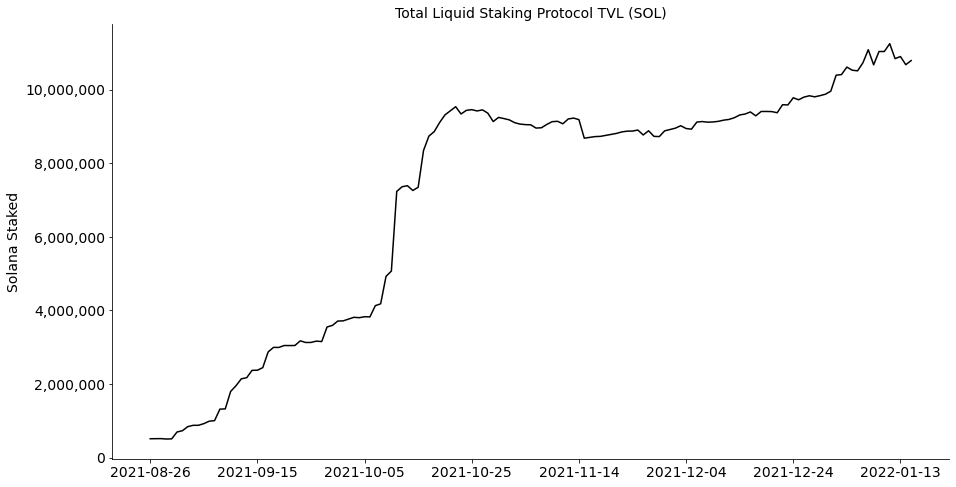

In [361]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
total = df['sum']

plt.plot(x,total, label='Total SOL Staked', color ='Black')


#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.title('Total Liquid Staking Protocol TVL (SOL)', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

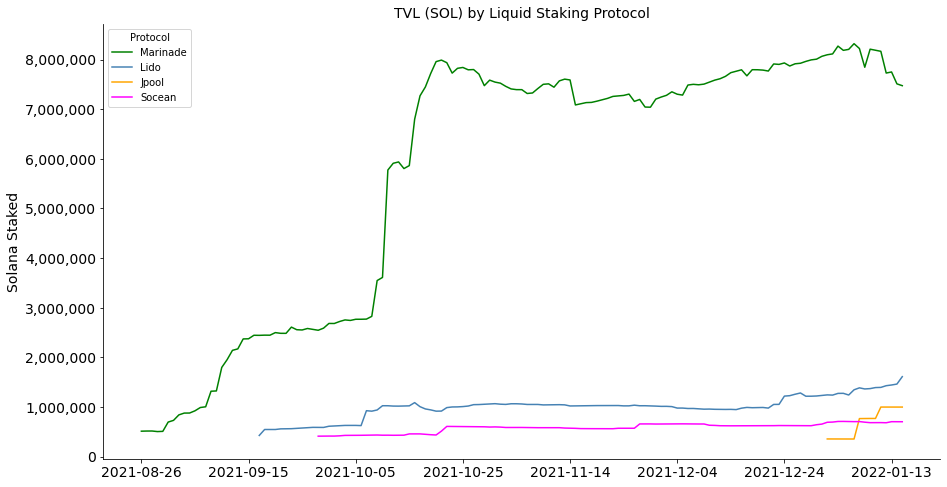

In [362]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
marinade = df['marinade_sol']
lido = df['lido_sol']
jpool = df['jpool_sol']
socean = df['socean_sol']

plt.plot(x,marinade, label='Marinade', color ='Green')
plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Liquid Staking Protocol', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

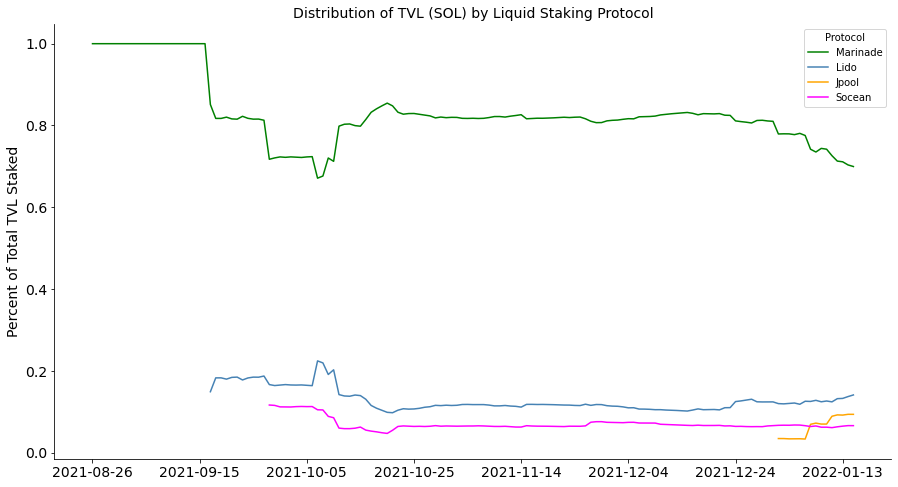

In [354]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
marinade = df['marinade_distribution']
lido = df['lido_distribution']
jpool = df['jpool_distribution']
socean = df['socean_distribution']

plt.plot(x,marinade, label='Marinade', color ='Green')
plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('Distribution of TVL (SOL) by Liquid Staking Protocol', fontsize=14) # adding a title
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Percent of Total TVL',fontsize=14) # y label
plt.show()

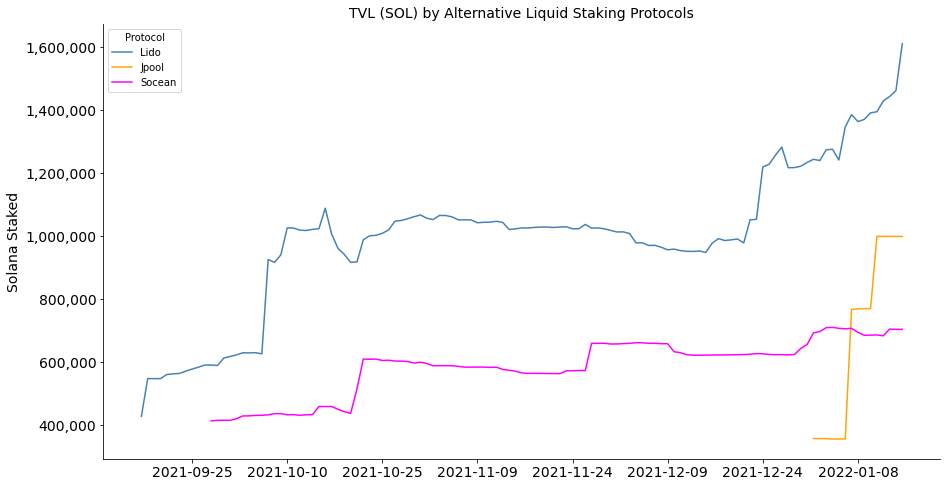

In [367]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
lido = df['lido_sol']
jpool = df['jpool_sol']
socean = df['socean_sol']

plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Alternative Liquid Staking Protocols', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

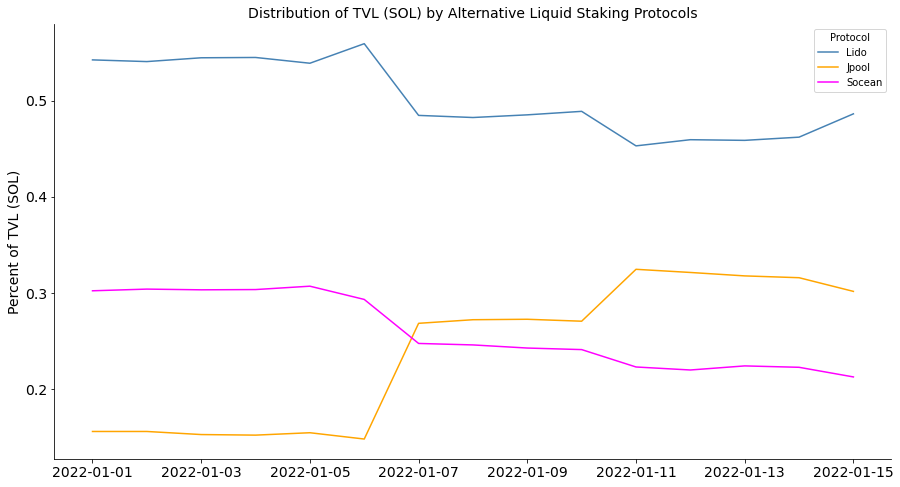

In [366]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
lido = df['lido_comp_distribution']
jpool = df['jpool_comp_distribution']
socean = df['socean_comp_distribution']

plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('Distribution of TVL (SOL) by Alternative Liquid Staking Protocols', fontsize=14) # adding a title
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Percent of TVL (SOL)',fontsize=14) # y label
plt.show()

In [307]:
df.to_csv('liquid_staking.csv')